In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from torch import nn
from sklearn.model_selection import train_test_split

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
data_df = pd.read_excel(r'../../data/custom_data_5.xlsx')

In [43]:
X=data_df.iloc[:,:2].to_numpy(dtype=float)
y = data_df['Color Class'].to_numpy(dtype=float)

In [44]:
X,y = torch.from_numpy(X).type(torch.float).to(device),torch.from_numpy(y).type(torch.float).to(device)

In [113]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=78)

In [114]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2048, 512, 2048, 512)

In [110]:
X_train.device,X_test.device,y_train.device,y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [97]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),

    
).to(device)

In [98]:

#loss function 
loss_fn = torch.nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [99]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_true))*100
    return acc

In [100]:
epochs = 10000

for epoch in range(epochs):

    model_0.train()

    train_logits=model_0(X_train).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logits))


    train_loss = loss_fn(train_logits,y_train)
    train_acc = accuracy_fn(y_train,train_pred)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():

        test_logits=model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

    if test_acc>99.80 or epoch>2000:
        print(f'Testing accuracy has reached {test_acc:.2f}% in {epoch} epochs')
        break

    if epoch % 10 == 0 :
        
        print(f'epoch: {epoch}, training loss:{train_loss}, testing loss:{test_loss}, training acc:{train_acc},testing acc:{test_acc}')


epoch: 0, training loss:0.6945772171020508, testing loss:0.6943299770355225, training acc:48.92578125,testing acc:48.4375
epoch: 10, training loss:0.6870722770690918, testing loss:0.6868909597396851, training acc:59.5703125,testing acc:70.703125
epoch: 20, training loss:0.6812825798988342, testing loss:0.6811028718948364, training acc:83.642578125,testing acc:77.9296875
epoch: 30, training loss:0.6756119728088379, testing loss:0.6754094958305359, training acc:70.60546875,testing acc:69.921875
epoch: 40, training loss:0.6691383123397827, testing loss:0.6689023971557617, training acc:71.19140625,testing acc:70.8984375
epoch: 50, training loss:0.6610792875289917, testing loss:0.6608176231384277, training acc:74.4140625,testing acc:73.046875
epoch: 60, training loss:0.6507366895675659, testing loss:0.6504587531089783, training acc:78.076171875,testing acc:76.7578125
epoch: 70, training loss:0.6371369361877441, testing loss:0.6368210315704346, training acc:82.6171875,testing acc:81.0546875


In [95]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    model.to(device)
    X, y = X.to(device), y.to(device)

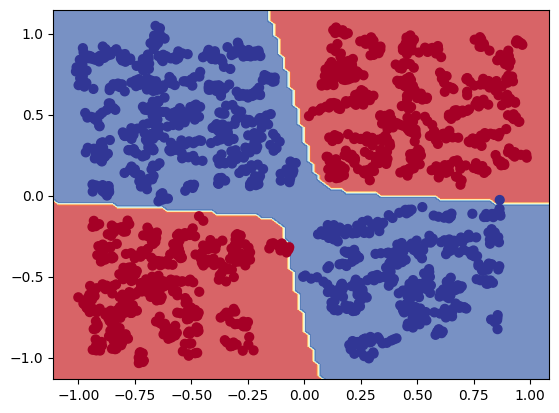

In [96]:

plot_decision_boundary(model_0,X_train,y_train)

In [115]:
model_0.eval()


with torch.inference_mode():
    y_logits=model_0(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

acc = accuracy_fn(y_test,y_pred)


In [116]:
acc

99.8046875

In [119]:
#saving the model 


model_path = r'../../models/model_0.pth'


torch.save(obj=model_0.state_dict(),f=model_path)

In [124]:
loaded_model_0=model_0

In [125]:
loaded_model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2559,  0.1017],
                      [ 0.7040, -0.8184],
                      [ 0.3684, -0.1266],
                      [-0.4652, -0.4994],
                      [ 0.2771,  0.7960],
                      [-0.6296, -0.4584],
                      [-0.0639,  0.2059],
                      [ 0.6693, -0.7848],
                      [ 0.1284, -0.0724],
                      [-0.3037,  0.6025],
                      [-0.7401, -0.6572],
                      [ 0.5231,  0.5431],
                      [-0.8709,  0.2081],
                      [-0.1996,  0.4325],
                      [ 0.2204,  0.4031],
                      [ 0.7465,  0.3493],
                      [-0.1020, -0.8145],
                      [-0.2829,  0.2674],
                      [ 0.7298,  0.7928],
                      [-0.6460,  0.4823],
                      [-0.0299, -0.0089],
                      [-0.2418,  0.4151],
                      [ 0.4575,  0.5292],
        